# Projekt ML: Predykcja Popularności Utworów Spotify
## Etap 3: Trenowanie i Ewaluacja Modelu
**Autor:** Grzegorz Zioło

W tym notatniku wykorzystuje przygotowany wcześniej pipeline (`src`) do wytrenowania modeli predykcyjnych.

**Cele:**
1. Sprawdzenie, jaki błąd (RMSE) daje proste zgadywanie średniej (`DummyRegressor`).
2. Zestawienie modelu liniowego (`LinearRegression`) z modelem nieliniowym (`XGBoost`).
3. Sprawdzenie, czy cechy zidentyfikowane w EDA (Gatunek, Acousticness, Explicit) faktycznie są najważniejsze dla modelu.

In [1]:
import sys
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge

sys.path.append(os.path.abspath('..'))

from src.loaders import DataLoaderFactory
from src.cleaners import SpotifyDataCleaner
from src.preprocessors import SpotifyPipelinePreprocessor
from src.trainers import ModelTrainer
from src.evaluation import ModelEvaluator

### 1. Uruchomienie Pipeline'u Danych (ETL)
Pobieram, czyszczę i przetwarzam dane (Skalowanie + One-Hot Encoding).

In [2]:
# Pobranie i czyszczenie danych
DATA_SOURCE = "hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv"
loader = DataLoaderFactory.get_loader(DATA_SOURCE)
cleaner = SpotifyDataCleaner()
clean_df = cleaner.clean(loader.load())

# Preprocessing
# target_col='popularity', zbiór: 80% trening / 20% test
preprocessor = SpotifyPipelinePreprocessor(target_col='popularity', test_size=0.2)
X_train, X_test, y_train, y_test = preprocessor.process(clean_df)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

X_train shape: (71792, 127)
X_test shape:  (17949, 127)


### 2. Inicjalizacja Narzędzi ML
Tworzę instancje klas pomocniczych:
* `ModelTrainer` - zajmuje się wywołaniem `.fit()` i mierzeniem czasu.
* `ModelEvaluator` - zajmuje się wyliczeniem $RMSE$/$R^2$ i rysowaniem wykresów.

In [4]:
trainer = ModelTrainer()
evaluator = ModelEvaluator()
results = []

### 3. Model 1: Baseline - wyznaczenie poziomu referencyjnego (Dummy Regressor)
Model "głupi", który dla każdego utworu przewiduje średnią popularność ze zbioru treningowego.
Celem tej operacji jest wyznaczenie "poziomu zero". Każdy sensowny model musi mieć mniejszy błąd niż wynik uzyskany tutaj.

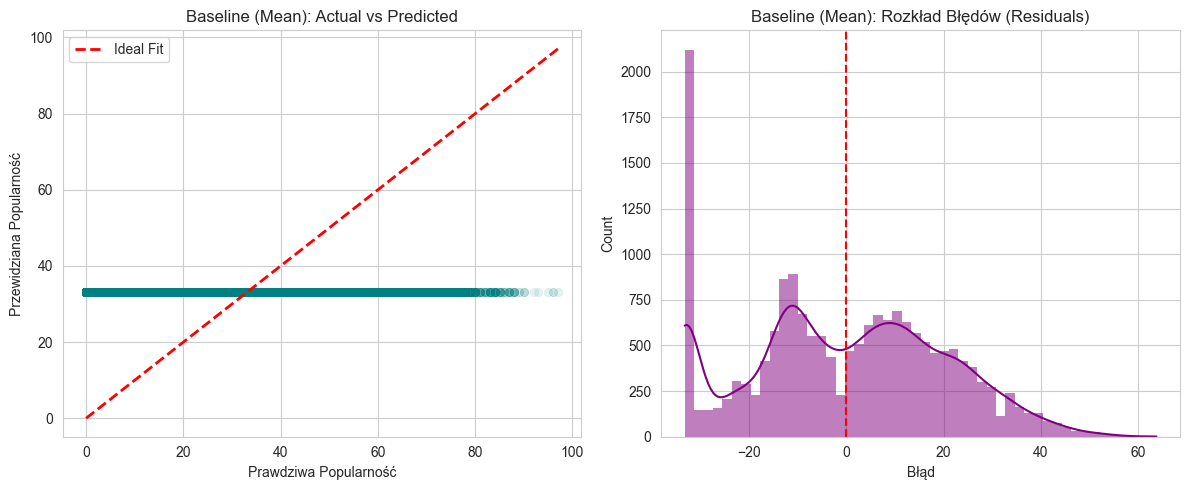

RMSE (Błąd): 20.4383
R2 (Wynik):  -0.0001


In [5]:
# Definicja modelu
dummy_model = DummyRegressor(strategy="mean")

# Trenowanie
trainer.train(dummy_model, X_train, y_train)

# Predykcja
y_pred_dummy = dummy_model.predict(X_test)

# Ewaluacja
res_dummy = evaluator.evaluate(y_test, y_pred_dummy, model_name="Baseline (Mean)")
results.append(res_dummy)

print(f"RMSE (Błąd): {res_dummy['rmse']:.4f}")
print(f"R2 (Wynik):  {res_dummy['r2']:.4f}")

**Wnioski**
* Uzyskany wynik $R^2 = -0.0001$ potwierdza, że model nie posiada żadnej zdolności predykcyjnej. Działa on jako prosty estymator średniej wartości popularności w zbiorze.
* Błąd średniokwadratowy wynosi 20.44. Oznacza to, że zgadując "na ślepo", mylimy się średnio o ponad 20 punktów na 100-stopniowej skali popularności.
  Jest to błąd akceptowalny dla losowego strzału, ale nieakceptowalny biznesowo.
* Wykres Residuals ujawnia bimodalny rozkład błędów (dwa "garby"). Wynika to z faktu, że model przewiduje stałą wartość (~30-35), podczas gdy prawdziwe dane mają dużo zer (utwory niepopularne) i dużo wartości wysokich (hity), a mało wartości średnich.

### 4. Model 2: Regresja Liniowa (Linear Regression)
Klasyczny model statystyczny.
Przediwuję, że model liniowy nie poradzi sobie dobrze z nieliniowymi zależnościami (np. "dzwon" czasu trwania), które wykazano w analizie EDA.

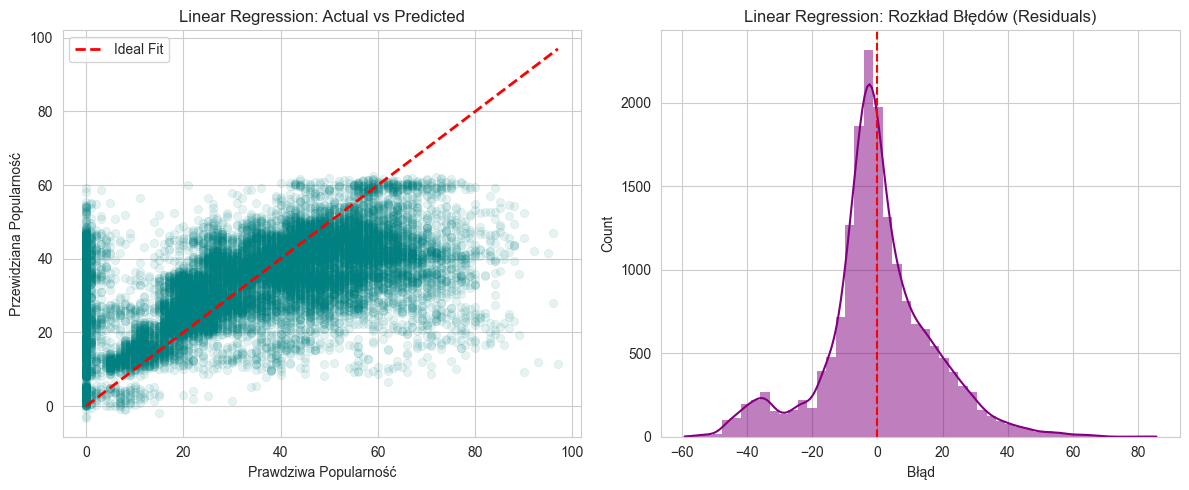

RMSE (Błąd): 16.8449
R2 (Wynik):  0.3207


In [6]:
# Definicja modelu
lr_model = LinearRegression()

# Trenowanie
trainer.train(lr_model, X_train, y_train)

# Predykcja
y_pred_lr = lr_model.predict(X_test)

# Ewaluacja
res_lr = evaluator.evaluate(y_test, y_pred_lr, model_name="Linear Regression")
results.append(res_lr)

print(f"RMSE (Błąd): {res_lr['rmse']:.4f}")
print(f"R2 (Wynik):  {res_lr['r2']:.4f}")

**Wnioski**
* Wynik $R^2 = 0.32$ oznacza, że udało nam się wyjaśnić 32% zmienności zmiennej celu.
* RMSE spadł z 20.44 do 16.84. Model "widzi" zależności, takie jak wpływ głośności czy przynależność do popularnych gatunków.
* Mimo poprawy, wynik 0.32 jest wciąż niezadowalający dla zastosowań produkcyjnych.
* Chmura punktów na wykresie Actual vs Predicted jest bardzo szeroka. Oznacza to, że dla wielu utworów model myli się drastycznie.
* Regresja Liniowa próbuje dopasować linię prostą, podczas gdy nasze EDA wykazało zależności nieliniowe (np. "dzwon" czasu trwania).
* Na wykresie Residuals widać wyraźne zaburzenie po lewej stronie (wartości ujemne). Model ma tendencję do przeszacowywania utworów o zerowej popularności, przypisując im wartości w okolicach 30-40 pkt.

Potrzebujemy modelu nieliniowego, który poradzi sobie ze złożonymi interakcjami cech.

### 5. Model 3: XGBoost (Extreme Gradient Boosting)
Model oparty na zespołach drzew decyzyjnych.
Doskonale radzi sobie z nieliniowością, rzadkimi macierzami (One-Hot) i outlierami.

Ustawiam `n_estimators=1000` i niski `learning_rate=0.05` dla stabilności.

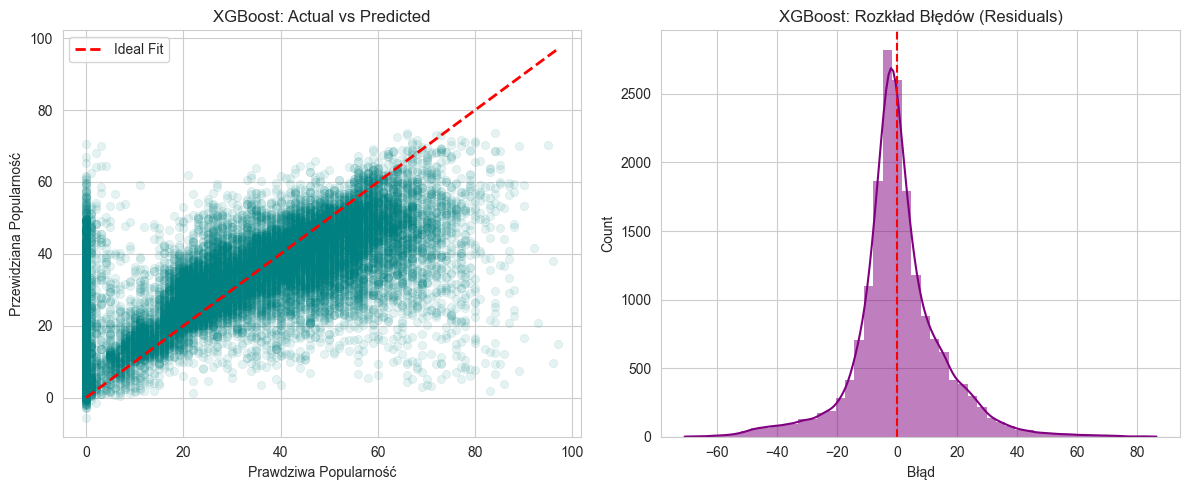

RMSE (Błąd): 14.9026
R2 (Wynik):  0.4683


In [12]:
# Definicja modelu
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,      # Duża liczba drzew
    learning_rate=0.05,     # Wolne uczenie (precyzyjne)
    max_depth=8,            # Głębokość drzewa (zbalansowana)
    subsample=0.8,          # Losowanie próbek (zapobiega overfittingowi)
    colsample_bytree=0.8,   # Losowanie cech (zapobiega overfittingowi)
    objective='reg:squarederror',
    n_jobs=-1,              # Użycie wszystkich rdzeni CPU
    random_state=42
)

# Trenowanie
trainer.train(xgb_model, X_train, y_train)

# Predykcja
y_pred_xgb = xgb_model.predict(X_test)

# Ewaluacja
res_xgb = evaluator.evaluate(y_test, y_pred_xgb, model_name="XGBoost")
results.append(res_xgb)

print(f"RMSE (Błąd): {res_xgb['rmse']:.4f}")
print(f"R2 (Wynik):  {res_xgb['r2']:.4f}")

**Wnioski**
* Model osiągnął $R^2 = 0.4683$, co stanowi znaczącą poprawę względem Regresji Liniowej ($0.32$).
* XGBoost skutecznie wyłapał nieliniowe zależności, których nie widział model liniowy (np. optymalny czas trwania, specyfika gatunków niszowych).
* RMSE = 14.90. Średni błąd zmalał o kolejne 2 punkty względem regresji i aż o 5.5 punktu względem Baseline.
* Na wykresie Residuals widzimy bardzo silną koncentrację błędów wokół zera (wysoka kurtoza). Oznacza to, że dla większości typowych utworów model jest bardzo precyzyjny.
* Wykres Actual vs Predicted pokazuje, że XGBoost lepiej radzi sobie z utworami o popularności 0. W przeciwieństwie do regresji liniowej, która często zawyżała ich ocenę, drzewa decyzyjne potrafią wydzielić segment "utworów niepopularnych" i przypisać im odpowiednio niską predykcję.

### 6. Analiza Ważności Cech (Feature Importance)

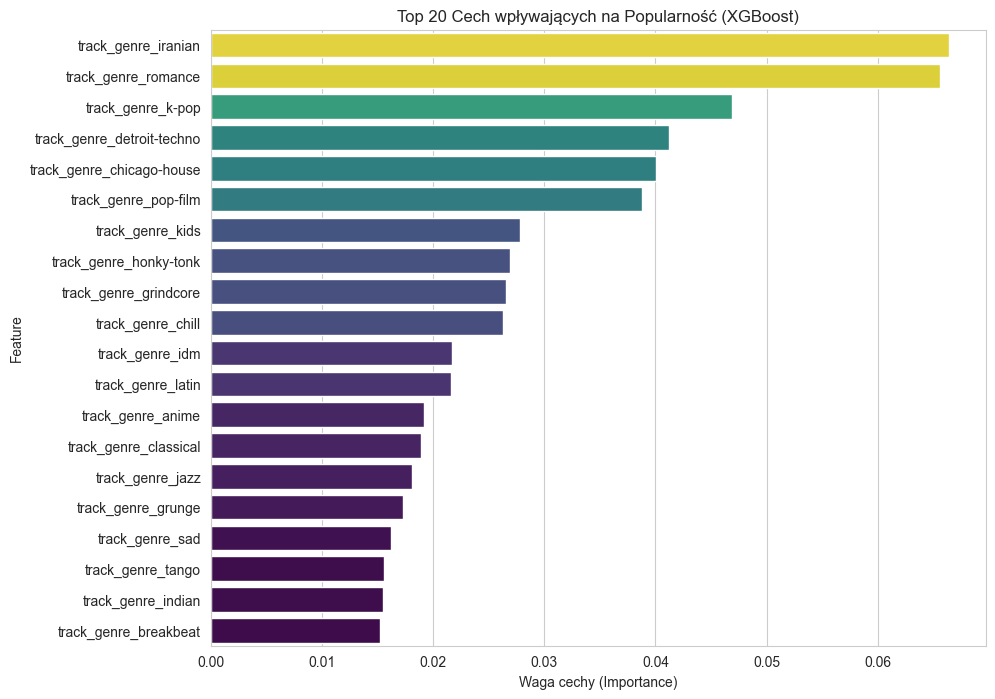

Najważniejsze cechy:


,Feature,Importance
73,track_genre_iranian,0.066391
107,track_genre_romance,0.065634
79,track_genre_k-pop,0.046916
38,track_genre_detroit-techno,0.041185
27,track_genre_chicago-house,0.040010
95,track_genre_pop-film,0.038771
80,track_genre_kids,0.027815
66,track_genre_honky-tonk,0.026926
56,track_genre_grindcore,0.026521
29,track_genre_chill,0.026251


In [8]:
# Pobranie nazw cech (z preprocessora)
feature_names = preprocessor.get_feature_names()

# Pobranie wag z modelu
importances = xgb_model.feature_importances_

# Stworzenie DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wizualizacja TOP 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), hue='Importance', palette='viridis', legend=False)
plt.title('Top 20 Cech wpływających na Popularność (XGBoost)')
plt.xlabel('Waga cechy (Importance)')
plt.show()

print("Najważniejsze cechy:")
feat_imp_df.head(10)

**Wnioski**
* Lista TOP 20 najważniejszych cech jest całkowicie zdominowana przez zmienne gatunkowe (np. `track_genre_iranian`, `track_genre_k-pop`, `track_genre_romance`).
* Przynależność do konkretnego gatunku jest najsilniejszym predyktorem sukcesu komercyjnego. Gatunek determinuje "sufit" i "podłogę" popularności – utwór *K-Popowy* ma statystycznie znacznie wyższy potencjał wiralowy niż utwór *Grindcore*, niezależnie od tego, jak został wyprodukowany.
* Jeśli utwór należy do gatunku niszowego (np. `iranian` na 1. miejscu), model drastycznie obniża predykcję. Jeśli należy do mainstreamu, podwyższa ją.
* Cechy audio (głośność, tempo, dancability) są ważne, ale pełnią rolę drugoplanową – służą do odróżnienia "dobrego" utworu od "złego" wewnątrz tego samego gatunku. Ponieważ jednak Feature Importance sumuje wpływ globalnie, specyficzne gatunki wysuwają się na prowadzenie.
* Aby zmaksymalizować szansę na hit, kluczowy jest wybór rynku docelowego (Gatunku). Nawet najlepiej wyprodukowany utwór w niszowym gatunku ma mniejsze szanse na globalną popularność (wg Spotify) niż przeciętny utwór w gatunku Pop-Film.

In [9]:
# Sprawdźmy, gdzie są cechy audio (nie zaczynające się od 'track_genre')
audio_features = feat_imp_df[~feat_imp_df['Feature'].str.startswith('track_genre_')]
print("Najważniejsze cechy audio:")
display(audio_features.head(15))

Najważniejsze cechy audio:


,Feature,Importance
1,explicit,0.001184
9,instrumentalness,0.001174
8,acousticness,0.001123
11,valence,0.001012
5,loudness,0.000996
12,tempo,0.000929
10,liveness,0.000917
7,speechiness,0.000910
3,energy,0.000866
2,danceability,0.000765


### 7. Podsumowanie Wyników

,rmse,mae,r2,name
0,20.438275,17.120757,-0.000078,Baseline (Mean)
1,16.844882,12.008196,0.320669,Linear Regression
2,14.902552,10.156727,0.468300,XGBoost


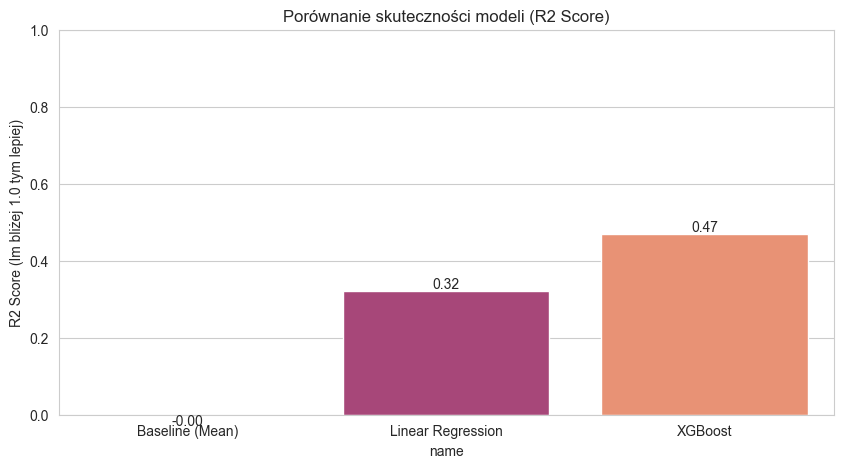

In [10]:
# Tworzymy tabelę podsumowującą
summary_df = pd.DataFrame(results)
display(summary_df)

# Wykres porównawczy R2
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='name', y='r2', data=summary_df, palette='magma', hue='name', legend=False)

# Dodanie etykiet z wartościami
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.title('Porównanie skuteczności modeli (R2 Score)')
plt.ylim(0, 1.0)
plt.ylabel('R2 Score (Im bliżej 1.0 tym lepiej)')
plt.show()

### 8. Finalne Wnioski

Przeprowadzony eksperyment pozwolił na wyłonienie najlepszego algorytmu do predykcji popularności utworów na Spotify.
Model XGBoost zmniejszył błąd średniokwadratowy (RMSE) o 27% w stosunku do modelu bazowego i o 11.5% w stosunku do regresji liniowej.
Średni błąd absolutny (MAE) dla XGBoost wynosi 10.15, co oznacza, że model myli się średnio o 10 punktów na 100-stopniowej skali. Jest to wynik pozwalający na skuteczne sortowanie katalogu muzycznego (np. odróżnianie potencjalnych hitów od utworów niszowych).
Znaczna przewaga modeli drzewiastych nad liniowymi potwierdza, że relacje w danych muzycznych są złożone i nieliniowe (np. specyfika gatunków, optymalny czas trwania).

### 8. Podsumowanie Projektu

Projekt pozwolił na precyzyjne określenie granic predykcji popularności w oparciu o same cechy audio.

Model XGBoost osiągnął $R^2 \approx 0.47$, $MAE \approx 10.1$. Model wyjaśnia blisko 50% zmienności popularności. Oznacza to, że gatunek i jakość produkcji (audio) to połowa sukcesu.
Błąd średni (MAE) na poziomie 10 punktów pozwala na skuteczne rozróżnianie utworów "słabych" (0-30) od "potencjalnych hitów" (60+), choć może mylić się w ocenie utworów przeciętnych.

Wynik $R^2 < 0.90$ wskazuje, że cechy audio nie są jedynym wyznacznikiem sukcesu. Brakujące 50% informacji to czynniki zewnętrzne, których nie posiadamy w tym zbiorze danych: budżet marketingowy, popularność artysty w social mediach, trendy na TikToku.
Model nie nadaje się do w pełni automatycznego podejmowania decyzji inwestycyjnych (ryzyko przeoczenia hitu opartego na "hypie", a nie na brzmieniu).

Model nadaje się do wdrożenia w roli systemu wspomagania decyzji:
* Jako filtr wstępny do przesiewania tysięcy nowych utworów demo. Model odrzuca utwory o niskim potencjale technicznym/gatunkowym, oszczędzając czas ekspertów.
* Szacowanie potencjału nowych utworów w serwisie streamingowym, które nie mają jeszcze historii odtworzeń (aby wiedzieć, komu je polecić na start).

Aby przekroczyć barierę $R^2 = 0.50$, rekomendowane jest wzbogacenie danych o metryki zewnętrzne (np. liczba obserwujących artystę na Instagramie/Spotify).